In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


## LIBRARIES:

In [ ]:
import numpy as np
import pandas as pd
import sqlite3
import re
from progressbar import ProgressBar

import os
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('seaborn-whitegrid')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [ ]:
def fn_append_path(data_path):

    import sys
    import os

    py_file_location = "/content/" + data_path
    sys.path.append(os.path.abspath(py_file_location))

In [ ]:
data_path = 'gdrive/My Drive/1A_WOC/2A_PROJECTS/1_AMAZON_FOOD_REVIEWS/DATA/'
fn_append_path(data_path)

In [ ]:
import aaic_mlfuncs as ai

# A.DATA:

In [ ]:
# LOADING SQLITE DATA INTO PANDAS DATAFRAMEText
con = sqlite3.connect(data_path + 'amazon_fine_food_reviews_database.sqlite')

%time df = pd.read_sql_query("""SELECT * FROM Reviews""", con)
df.info()

CPU times: user 2.75 s, sys: 589 ms, total: 3.34 s
Wall time: 5.84 s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
time = pd.to_datetime([int(i) for i in df.Time.values], unit = 's')
prod = df.ProductId
reviews = df.Text
ratings = df.Score

df_nlp = pd.DataFrame().assign(time = time, prod_id = prod,
                               reviews = reviews, ratings = ratings)

df_nlp.head()

,time,prod_id,reviews,ratings
0,2011-04-27,B001E4KFG0,I have bought several of the Vitality canned d...,5
1,2012-09-07,B00813GRG4,Product arrived labeled as Jumbo Salted Peanut...,1
2,2008-08-18,B000LQOCH0,This is a confection that has been around a fe...,4
3,2011-06-13,B000UA0QIQ,If you are looking for the secret ingredient i...,2
4,2012-10-21,B006K2ZZ7K,Great taffy at a great price. There was a wid...,5


### 1.DATA CLEANING & PREPROCESSING:

In [ ]:
df_nlp.reviews = df_nlp.reviews.str.lower()
df_nlp.prod_id = df_nlp.prod_id.str.lower()

df_nlp.fillna(' ', inplace = True)
df_nlp.drop_duplicates(['reviews'], inplace = True)

regex_pat_1 = re.compile(r'[^a-zA\n]') #---Matches all chars that are not alpha numeric
regex_pat_2 = re.compile(r'\s+') #---------Matches all excess spaces eg: '  '


%time df_nlp.reviews = df_nlp.reviews.str.replace(regex_pat_1, ' ').str.replace(regex_pat_2, ' ')

df_nlp.index = range(len(df_nlp))
df_nlp.sample(5)

CPU times: user 14 s, sys: 201 ms, total: 14.2 s
Wall time: 14.2 s


,time,prod_id,reviews,ratings
98730,2010-11-08,b0030f70lo,healthy treats for our standard american eskim...,5
255377,2012-07-27,b005bgrbm8,for those saying it doesn t pass the taste tes...,5
4095,2012-10-11,b001ew5yqs,this icicle performs flawlessly with very good...,5
124853,2012-07-09,b005grcwdu,lavazza coffee is the best coffee ever we love...,5
188737,2012-08-31,b0032jwe4q,i like my tea strong i normally drink pg tips ...,3


In [ ]:
df_nlp.shape

(393568, 4)

In [ ]:
df_nlp.to_csv(data_path + 'df_nlp.csv', index = False)

In [ ]:
df_nlp.reviews.isna().sum(axis = 0)

0

## QUICK START -1

In [ ]:
df_nlp = pd.read_csv(data_path + 'df_nlp.csv')
df_nlp.head(3)

## REMOVING LESS IMPORTANT PRODUCTS:

In [ ]:
def fn_df_nlp_top_prods(df_nlp, freq_thresh = 20):

    condition = df_nlp.prod_id.value_counts() >= freq_thresh
    df_freqs = df_nlp.prod_id.value_counts()[condition]
    listO_top_prod_ids = list(df_freqs.index )

    listO_filtered_idxs = []
    pbar = ProgressBar()

    for prod_id in pbar(listO_top_prod_ids):

        filtered_idxs = df_nlp[df_nlp.prod_id == prod_id].index
        listO_filtered_idxs += list(filtered_idxs)

    listO_filtered_idxs = list(set(listO_filtered_idxs))

    return df_nlp.iloc[listO_filtered_idxs]

In [ ]:
df_nlp_top_prods = fn_df_nlp_top_prods(df_nlp)

df_nlp_top_prods.sample(10)

100% (3467 of 3467) |####################| Elapsed Time: 0:01:13 Time:  0:01:13


,time,prod_id,reviews,ratings
228233,2011-03-26,b001eo772a,a great coffee in pre ground i don t have a co...,5
221818,2012-02-24,b0051coph6,span class tiny length mins br br span here a...,4
209569,2011-02-20,b004bklhos,amazon offered apple cinnamon and golden honey...,5
305287,2011-09-22,b002gq3idc,i grew up within an indian community and have ...,5
21336,2009-12-05,b000kv61fc,i wanted to use this as an alternative to a ko...,2
143608,2011-06-15,b001b3jal0,i really really love pop chips they are much l...,4
37456,2011-03-07,b00017ley8,i cannot believe the vendor had the nerve to s...,1
175234,2008-01-07,b0009xuax0,great products easy to deal with i order from ...,5
355251,2011-02-24,b000n33nsu,i first purchased erin baker s breakfast cooki...,5
245210,2012-06-25,b001j8h1e0,my dogs love these and its great to finally fi...,5


In [ ]:
df_nlp_top_prods.shape

(184574, 4)

## TRAIN - TEST SPLIT:

In [ ]:
import aaic_mlfuncs as ai

df_Xy = df_nlp_top_prods
idxs_tr, idxs_ts = ai.fn_tr_ts_split_clf(df_Xy, ts_size = 0.2)

df_tr = df_Xy.iloc[idxs_tr]
df_ts = df_Xy.iloc[idxs_ts]

df_tr.index = range(len(df_tr))
df_ts.index = range(len(df_ts))

df_tr.shape, df_ts.shape

((147659, 4), (36915, 4))

In [ ]:
df_ts.head()

,time,prod_id,reviews,ratings
55636,2008-04-13,b001e5e05g,this is one of the better dry cold cereals on ...,5
21467,2010-08-13,b000kv61fc,i thought this would be fantastic to keep my p...,1
156135,2012-10-20,b001eo5q64,this stuff nutiva organic extra virgin coconut...,5
127260,2012-06-11,b000e8wias,it took about drops for coffe and for green te...,3
86970,2011-05-06,b003v5v5j6,was very surprised on how strong the flavors a...,5


In [ ]:
df_tr.index = range(len(df_tr))
df_ts.index = range(len(df_ts))

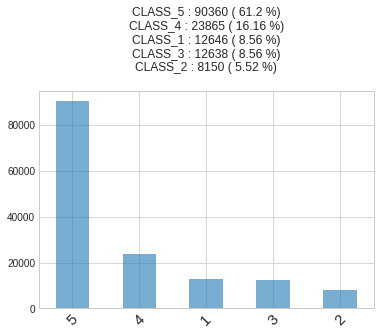

In [ ]:
y = df_tr.ratings.values

ai.fn_distr_labels_clf(y)

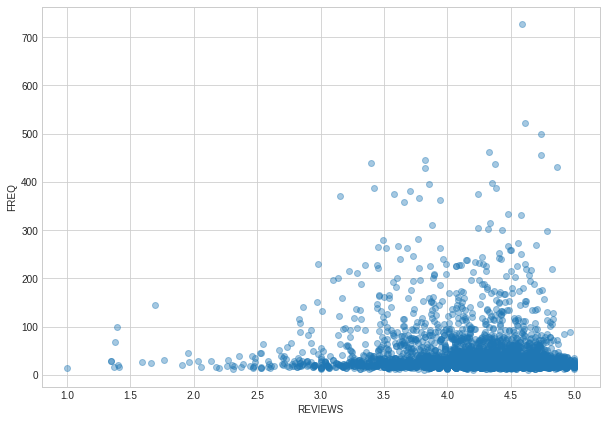

In [ ]:
df_prod_ratings = df_tr.groupby('prod_id').mean().sort_values(by = 'ratings', ascending = False)
df_prod_freq = df_tr.prod_id.value_counts()
df_prod_rating_freq = pd.concat([df_prod_ratings, df_prod_freq], axis = 1)
df_prod_rating_freq.columns = ['ratings', 'freq']

plt.figure(figsize = (10, 7))
plt.scatter(df_prod_rating_freq.ratings, df_prod_rating_freq.freq, alpha = 0.4)
plt.xlabel('REVIEWS')
plt.ylabel('FREQ')
plt.show()

In [ ]:
cond_1 = df_prod_rating_freq.ratings >= 3.5
cond_2 = df_prod_rating_freq.freq >= 400

df_top_prods = df_prod_rating_freq[cond_1 & cond_2]
df_top_prods

,ratings,freq
b000nmjwzo,4.867749,431
b003b3oopa,4.737475,499
b001eo5q64,4.736264,455
b002qwp89s,4.609195,522
b007jfmh8m,4.590096,727
b000ubd88a,4.376147,436
b0013nugde,4.331169,462
b0090x8ipm,3.825175,429
b005k4q37a,3.820225,445


In [ ]:
df_tr[df_tr.prod_id == df_top_prods.index[0]].reviews.sample(5).values

array(['when we first started using this stuff we were on the subscribe and save program getting pound bags every months and that s just for people we were eating pancakes every morning we ve slowed down a bit since but still love this mix it s great for pancakes biscuits sweet breads etc and it s gluten free ',
       'i love this mix because i ve been able to use it to recreate some old family recipes the ones grandma would make for us as kids which i have such fond memories of who could ask for more than that it doesn t have any bean flour in it so it doesn t have that aftertaste that is common in other mixes there are some great recipes on pamela s website as well especially the one for cornbread it really taste good to mix butter or margarine with some roasted pecans and a little honey as a topping for it it makes really good pancakes too the bread recipe makes a nice loaf but i would consider it a desert bread so although it does ok even if it isn t toasted it s not really good f

In [ ]:
df_tr[df_tr.prod_id == df_top_prods.index[1]].reviews.sample(5).values

array(['this is a must have if you re a college student cooking for yourself i can use this on the pan i can use this on a banana sandwich which is delicious with speculoos and lightly toasted bread and sometimes i just stick it into whatever is in the pot just for fun coconut oil is good for your health it smells great too ',
       'i love this stuff i use it on my skin and it drinks it up i put it in my hair before washing and my hair looks great and hydrated i really like this stuff i moisturize my face with it at night as well it s really an amazing product bravo and i m so happy i bought this ',
       'i was rather disappointed with this product first it arrived totally melted and liquified to the company s everlasting credit they gave me a full refund the level of customer service was excellent but i found this product to be greasy and unwieldy i used it as a body lotion but felt slimy i also tried to massage it on my cat who usually enjoys a kitty spa experience and he ran fro

In [ ]:
df_tr[df_tr.prod_id == df_top_prods.index[2]].reviews.sample(5).values

array(['i bought this product for my hair because of other people s reviews my hair was brittle and looked horrible because i color it often and use a flat iron almost daily i started using this product and my hair looks youthful and shiny again i have paid hundreds of dollars on conditioners and nothing worked better than coconut oil love the fact that you get two of these its a great deal ',
       'great product quick shipment great price i love love love coconut oil and it s quite pricey i should have purchased more and keep them stocked i use it on my hair skin',
       'i got this because i had read on another website that this product was great for using in place of butter and for skin care well i don t like using it in place of butter it is very tasty with no phony aftertaste or anything i have used it when making certain things on the stove where i would use butter mostly i use it for items that are on the sweeter side it s very good on toast too almost like having dessert br 

In [ ]:
df_tr[df_tr.prod_id == df_top_prods.index[3]].reviews.sample(5).values

array(['i ll admit i am reviewing a product i have not used the reason is that wheat gluten is about the cause of allergies in dogs when wheat gluten is broken down it gets very sticky so it coats the cilia of the digestive tract this can cause irritation and cause the immune system to actually destroy the lining of the intestines this means that your pup might not be able to absorb all the nutrients he is eating br br often allergies show up as hot spots where the dog gets itchy and possibly scratches fur off the problem with food allergies is it s possible that they won t be obvious because all the damage will be internal br br so i have not seen a problem with this product but i have known dogs who have had terrible reactions to wheat it s the same things as gluten intolerance in humans but it s much more common in dogs who are not quite as good at digesting grains wheat flour can be bad enough but including concentrated wheat protein is much worse because that is what causes the al

In [ ]:
df_tr[df_tr.prod_id == df_top_prods.index[4]].reviews.sample(5).values

array(['i loved these cookies they are chewy and moist and the raisins are not hard or gummy they are very fresh and plump they bring back memories of grandmas kitchen ',
       'i received a quaker soft baked oatmeal raisin cookie from influenster to try and review i shared this with my son who does not like oatmeal and he loved it i love that it is made with whole grains and could be a good substitute for an on the go breakfast when i am running behind the flavoe is very good i love the soft texture i really don t care for hard cookies and this one is perfect i would recomeend this product to others and will probably purchase some more for my family ',
       'my daughter loved my free sample of this cookie from influenster she goobled it right down which i didn t think she would she s not the biggest fan of rasins i tried a bite and thought it was kinda dry myself but if my daughter loves it i will buy it again ',
       'delicious and soft treat perfect to store in a purse or diape

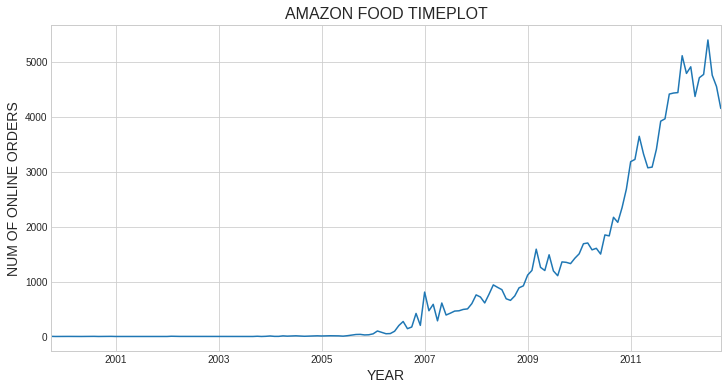

In [ ]:
freq = [1 for i in range(len(df_tr))]
df_timestamp = pd.DataFrame().assign(prod_id = df_tr.prod_id, freq = freq)
df_timestamp.index = df_tr.time

fig, ax = plt.subplots(figsize=(12,6))

df_timestamp.freq.resample('M').sum().plot(ax=ax)
ax.set_title('AMAZON FOOD TIMEPLOT', fontsize = 16)
ax.set_ylabel('NUM OF ONLINE ORDERS', fontsize = 14)
ax.set_xlabel('YEAR', fontsize = 14)
ax.xaxis.set_ticks_position('bottom')
plt.show()

### SAVE TRAIN AND TEST SETS:

In [ ]:
# df_tr.to_csv(data_path + 'df_nlp_tr.csv', index = False)
# df_ts.to_csv(data_path + 'df_nlp_ts.csv', index = False)

In [ ]:
corpus = df_tr.reviews.values
kwargs = dict(min_df=10, max_features = 3000,
              ngram_range = (1,1), stop_words = {'english'})


%time BOW_vectorizer = CountVectorizer(**kwargs).fit(corpus)
%time bow_matrix = BOW_vectorizer.transform(corpus)

bow_matrix.shape

## 2.TFIDF:

In [ ]:
df_tr = pd.read_csv(data_path + 'df_nlp_tr.csv')
df_ts = pd.read_csv(data_path + 'df_nlp_ts.csv')

In [ ]:
corpus = df_tr.reviews.values
kwargs = dict(min_df=10, max_features = 3000,
              ngram_range = (1,1), stop_words = {'english'})

%time TFIDF_vectorizer = TfidfVectorizer(**kwargs).fit(corpus)
%time tfidf_matrix = TFIDF_vectorizer.transform(corpus)

tfidf_matrix.shape

CPU times: user 7.49 s, sys: 121 ms, total: 7.61 s
Wall time: 7.63 s
CPU times: user 7.74 s, sys: 3.49 ms, total: 7.74 s
Wall time: 7.76 s


(147659, 3000)

In [ ]:
ts_tfidf_matrix = TFIDF_vectorizer.transform(df_ts.reviews.values)

ts_tfidf_matrix.shape

(36915, 3000)

##3. WORD2VEC:

In [ ]:
from gensim.models import KeyedVectors

load_w2v = KeyedVectors.load_word2vec_format
name = 'GoogleNews-vectors-negative300.bin'
w2v_google = load_w2v(data_path + name, binary=True)

w2v_dims = w2v_google['wizard'].shape[0]
w2v_dims

300

## 4. TF IDF WEIGHED W2V:

In [ ]:
def fn_w2v(word, weight):
    try:
        word_vec = w2v_model[word]
    except:
            word_vec = np.zeros(w2v_dims)
    return list(word_vec * weight)

In [ ]:
def fn_tfidf_w2v(tfidf_matrix, tfidf_features, w2v_model, w2v_dims = 300):

    pbar = ProgressBar(max_value = tfidf_matrix.shape[0])
    listO_weighed_w2c_doc_vecs = []

    c, missed_rows = 0, []
    for tfidf_row in pbar(tfidf_matrix):

        non_zero_idxs = tfidf_row.toarray().squeeze().nonzero()[0]

        if len(non_zero_idxs) == 0:
            missed_rows.append(c)
            c += 1
            continue

        doc_weights = tfidf_row.toarray().squeeze()[non_zero_idxs]
        doc_words = np.array(tfidf_features)[non_zero_idxs]

        iter = zip(doc_words, doc_weights)
        weighed_word_vecs = np.array([fn_w2v(word, weight) for word, weight in iter])
        weighed_w2c_doc_vecs = sum(weighed_word_vecs)/(sum(doc_weights) + 1e-5)
        listO_weighed_w2c_doc_vecs.append(list(weighed_w2c_doc_vecs))

        pbar.update()
        c += 1

    arryO_weighed_w2c_doc_vecs = np.array(listO_weighed_w2c_doc_vecs)
    return arryO_weighed_w2c_doc_vecs, missed_rows

In [ ]:
tfidf_features = TFIDF_vectorizer.get_feature_names()
w2v_model = w2v_google

z = fn_tfidf_w2v(tfidf_matrix, tfidf_features, w2v_model)
arryO_tfidf_word_vecs, missed_rows = z

arryO_tfidf_word_vecs.shape, len(missed_rows)

100% (147659 of 147659) |################| Elapsed Time: 0:07:04 Time:  0:07:04


((147657, 300), 2)

In [ ]:
missed_rows

[87031, 112580]

In [ ]:
tfidf_features = TFIDF_vectorizer.get_feature_names()
w2v_model = w2v_google

z = fn_tfidf_w2v(ts_tfidf_matrix, tfidf_features, w2v_model)
ts_arryO_tfidf_word_vecs, ts_missed_rows = z

ts_arryO_tfidf_word_vecs.shape, len(ts_missed_rows)

100% (36915 of 36915) |##################| Elapsed Time: 0:01:46 Time:  0:01:46


((36914, 300), 1)

In [ ]:
ts_missed_rows

[28833]

## SAVE DOCUMENT VECTORS:

In [ ]:
arr = arryO_tfidf_word_vecs
file = 'arryO_tfidf_word_vecs.npy'

np.save(data_path + file, arr, allow_pickle=True, fix_imports=True)

In [ ]:
arr = ts_arryO_tfidf_word_vecs
file = 'ts_arryO_tfidf_word_vecs.npy'

np.save(data_path + file, arr, allow_pickle=True, fix_imports=True)

In [ ]:
arryO_tfidf_word_vecs = np.load(data_path + 'arryO_tfidf_word_vecs.npy')
ts_arryO_tfidf_word_vecs = np.load(data_path + 'ts_arryO_tfidf_word_vecs.npy')

In [ ]:
df_tr = pd.read_csv(data_path + 'df_nlp_tr.csv')
df_ts = pd.read_csv(data_path + 'df_nlp_ts.csv')

In [ ]:
missed_rows = [87031, 112580]
ts_missed_rows = [28833]

In [ ]:
X_train = arryO_tfidf_word_vecs
X_test = ts_arryO_tfidf_word_vecs

y_tr = df_tr.drop(missed_rows).ratings.values
y_ts = df_ts.drop(ts_missed_rows).ratings.values

X_train.shape, X_test.shape, y_tr.shape, y_ts.shape

((147657, 300), (36914, 300), (147657,), (36914,))

### CONVERTING LABELS FROM RATINGS TO POSITIVE AND NEGATIVE CLASS:

In [ ]:
y_train = np.array([1 if int(i) >=3 else 0 for i in y_tr])
y_test = np.array([1 if int(i)>=3 else 0 for i in y_ts])

In [ ]:
df_tr_set = pd.DataFrame(X_train).assign(labels = y_train)
df_ts_set = pd.DataFrame(X_test).assign(labels = y_test)

## VISUALIZING DIMENSIONALLY REDUCED DATA:

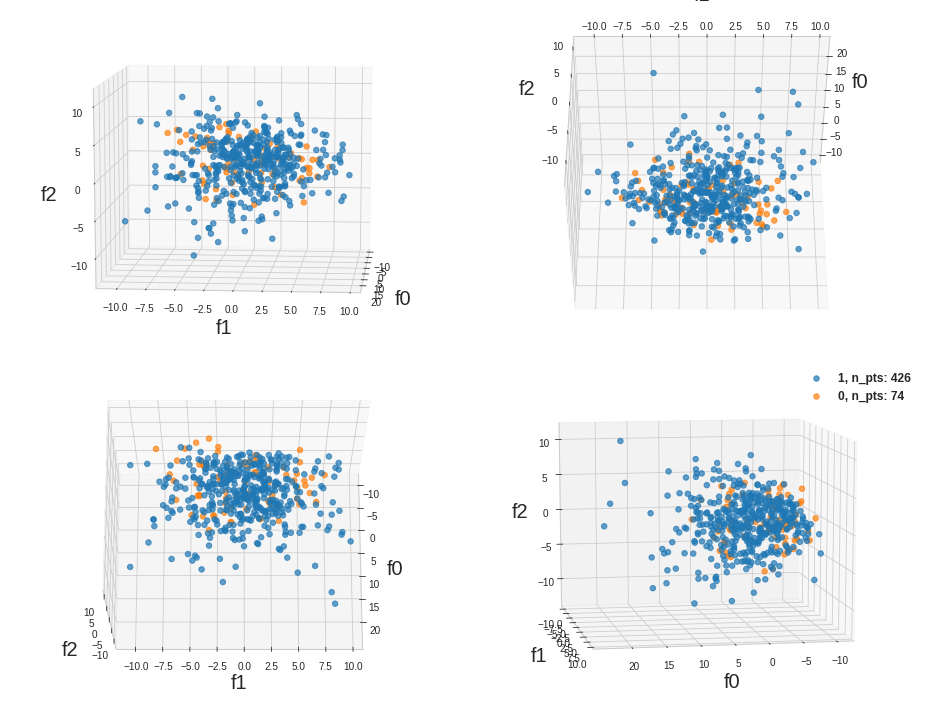

In [ ]:
df_pca, pca_transformer = ai.fn_PCA(df_tr_set)

ai.fn_plot_3d_clf(df_pca.sample(500), alpha = 0.7)

In [ ]:
arr = X_train
file = 'X_train.npy'

np.save(data_path + file, arr, allow_pickle=True, fix_imports=True)

arr = X_test
file = 'X_test.npy'

np.save(data_path + file, arr, allow_pickle=True, fix_imports=True)

arr = y_train
file = 'y_tr.npy'

np.save(data_path + file, arr, allow_pickle=True, fix_imports=True)

arr = y_train
file = 'y_ts.npy'

np.save(data_path + file, arr, allow_pickle=True, fix_imports=True)

In [ ]:
X_train = np.load(data_path + 'X_train.npy')
X_test = np.load(data_path + 'X_test.npy')
y_train = np.load(data_path + 'y_tr.npy')
y_test = np.load(data_path + 'y_ts.npy')

### KFOLD CROSS VALIDATION + HYPERPARAMETER TUNING (GRID SEARCH):

In [ ]:
from sklearn.linear_model import LogisticRegression

model_class = LogisticRegression

parameter_grid = dict(penalty = ['l2', 'l1', 'elasticnet'],
                            C = [10**i for i in range(-15, 15)],
                       solver = ['saga'],
                 class_weight = ['balanced'],
                     max_iter = [10_000])

z = ai.fn_kfoldcv_clf_binary(X_train, y_train.reshape(-1, 1),
                             model_class,  parameter_grid)

df_kfoldcv_gridsearch, dictO_model_instances = z
df_kfoldcv_gridsearch.describe()

100% (90 of 90) |########################| Elapsed Time: 0:30:28 Time:  0:30:28


,ts_mean_rec_1,ts_mean_prec_1,ts_mean_rec_0,ts_mean_prec_0,ts_mean_loss,ts_std_loss,ts_mean_acc,ts_std_rec_1,ts_std_rec_0
count,5.700000e+01,57.000000,5.700000e+01,57.000000,57.000000,5.700000e+01,57.000000,57.000000,57.000000
mean,7.101490e-01,0.951781,7.257275e-01,0.423895,0.523538,1.622533e-03,0.712343,0.084251,0.088087
std,1.969366e-01,0.026316,2.015559e-01,0.159407,0.119777,1.005969e-03,0.167270,0.180170,0.178399
min,2.364793e-11,0.859160,1.442585e-10,0.140840,0.435661,3.889452e-09,0.140840,0.000000,0.000000
25%,6.713174e-01,0.953053,7.205713e-01,0.394023,0.435775,1.416861e-03,0.678065,0.001950,0.006518
50%,7.954218e-01,0.962617,8.115503e-01,0.394061,0.435775,1.726580e-03,0.797693,0.001951,0.006518
75%,7.954296e-01,0.962617,8.115503e-01,0.394061,0.691030,1.726737e-03,0.797700,0.001960,0.009130
max,1.000000e+00,1.000000,1.000000e+00,1.000000,0.696098,4.813510e-03,0.859160,0.471405,0.471405


## FILTER OUT BEST PERFORMING MODELS (TOP MODELS):

In [ ]:
dff = df_kfoldcv_gridsearch
n = 15

df1 = dff.sort_values(by = 'ts_mean_rec_1', ascending = False)[:n]
df2 = dff.sort_values(by = 'ts_mean_prec_1', ascending = False)[:n]
df3 = dff.sort_values(by = 'ts_std_rec_1', ascending = True)[:n]
df4 = dff.sort_values(by = 'ts_mean_loss', ascending = True)[:n]
df5 = dff.sort_values(by = 'ts_std_loss', ascending = False)[:n]

df_filtered_cv = pd.concat([df1, df2, df3, df4, df5]).drop_duplicates()
df_filtered_cv = df_filtered_cv[df_filtered_cv.ts_mean_loss < 0.5]
df_filtered_cv = df_filtered_cv.sort_values(by = 'ts_mean_rec_1', ascending = False)[:3]
df_filtered_cv

,ts_mean_rec_1,ts_mean_prec_1,ts_mean_rec_0,ts_mean_prec_0,ts_mean_loss,ts_std_loss,ts_mean_acc,ts_std_rec_1,ts_std_rec_0
model_45,0.795453,0.962627,0.811598,0.394103,0.435760,0.001723,0.797727,0.001912,0.006507
model_28,0.795430,0.962617,0.811550,0.394061,0.435775,0.001727,0.797700,0.001951,0.006518
model_17,0.795430,0.962617,0.811550,0.394061,0.435775,0.001727,0.797700,0.001951,0.006518


## INSPECTING THE PARAMETERS OF THE CHOSEN MODELS:

In [ ]:
[dictO_model_instances[i] for i in df_filtered_cv.index]

[LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=10000,
                    multi_class='auto', n_jobs=None, penalty='l1',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=10000000000000, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=10000, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=None, solver='saga', tol=0.0001,
                    verbose=0, warm_start=False),
 LogisticRegression(C=100, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=10000, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=None, solver='saga', tol=0.0001,
                    verb

## INSPECT PERFORMANCE OF TOP MODELS (PLOT PRECISON RECALL CURVES):

In [ ]:
df_tr_set = pd.DataFrame(X_train).assign(labels = y_train)
df_ts_set = pd.DataFrame(X_test).assign(labels = y_test)

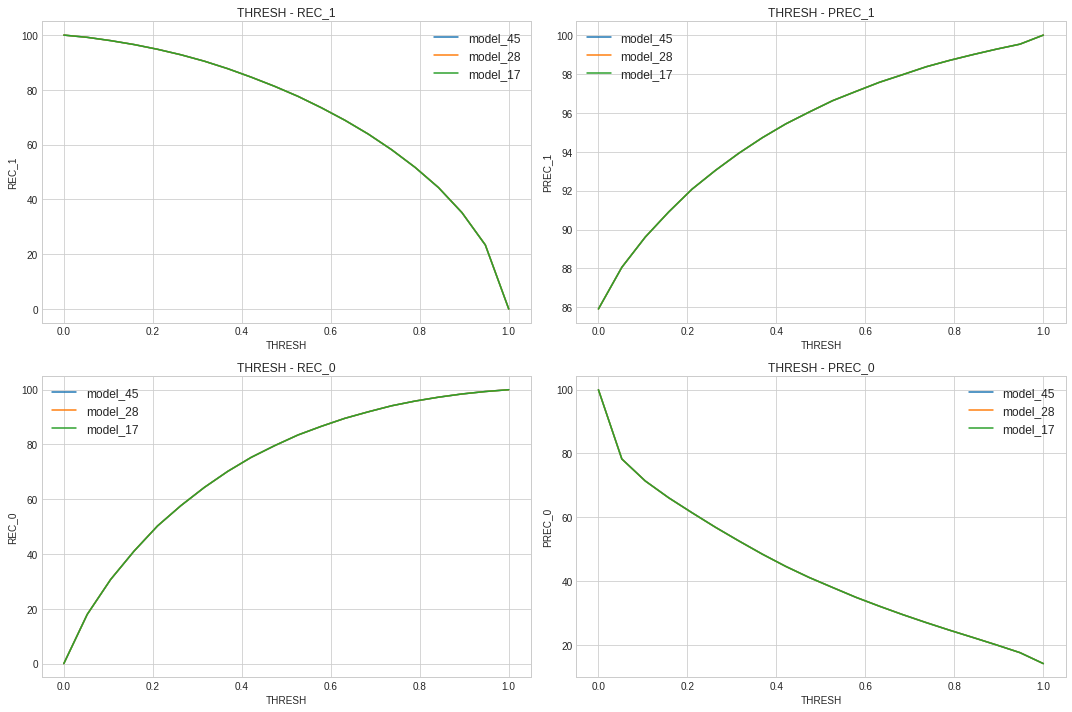

In [ ]:
df_tr_standard, df_ts_standard, scaler = ai.fn_standardize_df(df_tr_set, df_ts_set)

listO_model_names = list(df_filtered_cv.index)
X_train, y_train = df_tr_standard.iloc[:, :-1].values, df_tr_standard.iloc[:, -1].values
listO_models = [dictO_model_instances[i].fit(X_train, y_train) for i in listO_model_names]

listO_thresholds = np.linspace(0, 1, 20)
legend = listO_model_names

ai.fn_performance_models_data(listO_models, df_tr_standard, listO_thresholds, legend)

## TESTING CHOSEN MODEL FOR GENERALIZATION PURFORMANCE:

In [ ]:
df_Xy_ = df_tr_standard
model_ = dictO_model_instances['model_45'].fit(X_train, y_train)
thresh = 0.2

ai.fn_test_model_binary_clf(df_Xy_, model_, threshold_class_1 = thresh)

--------------------
LOGLOSS : 0.4334
ACCURACY: 88.607
--------------------



,prec,rec
class_0,62.267,48.500
class_1,91.853,95.182


In [ ]:
df_Xy_ = df_ts_standard

ai.fn_test_model_binary_clf(df_Xy_, model_, threshold_class_1 = thresh)

--------------------
LOGLOSS : 0.4376
ACCURACY: 88.498
--------------------



,prec,rec
class_0,61.815,47.952
class_1,91.770,95.144


***